In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from tqdm import tqdm
from helper_functions import *
maindir = "/Users/hieunguyen/data/BS_features"
outdir = "/Users/hieunguyen/data/outdir"
data_version = "20240822"
PROJECT_nonBS = "WGS_feature_dist_distance"
PROJECT_BS = "WGBS_feature_dist_distance"

output_version = "20240822"

path_to_03_output = os.path.join(outdir, output_version, "compare_optimal_transport_dist", "03_output")

path_to_main_input = os.path.join(maindir, data_version)

metadata = pd.read_csv("full_metadata.csv")
metadata = metadata[metadata["Label"] == "Control"]
feature_name = "EM"

bsdf = pd.read_csv(os.path.join(outdir, PROJECT_BS, output_version, "01_output_BS",  "{}.{}.csv".format("Control", feature_name)), index_col = [0])
nonbsdf = pd.read_csv(os.path.join(outdir, PROJECT_nonBS, output_version, "01_output",  "{}.{}.csv".format("Control", feature_name)), index_col = [0])

import Levenshtein
import itertools
nucleotides = ['A', 'C', 'G', 'T']
motifs = [''.join(p) for p in itertools.product(nucleotides, repeat=4)]

# Initialize an empty distance matrix
distance_matrix = pd.DataFrame(index=motifs, columns=motifs)

# Compute the Levenshtein distance between each pair of 4-mer motifs
for motif1 in motifs:
    for motif2 in motifs:
        distance_matrix.loc[motif1, motif2] = Levenshtein.distance(motif1, motif2)

# Convert the distance matrix to integer type

M = distance_matrix.to_numpy().copy()
M /= M.max() * 0.1

bsdf = bsdf.loc[motifs].copy()
nonbsdf = nonbsdf.loc[motifs].copy()



<Axes: >

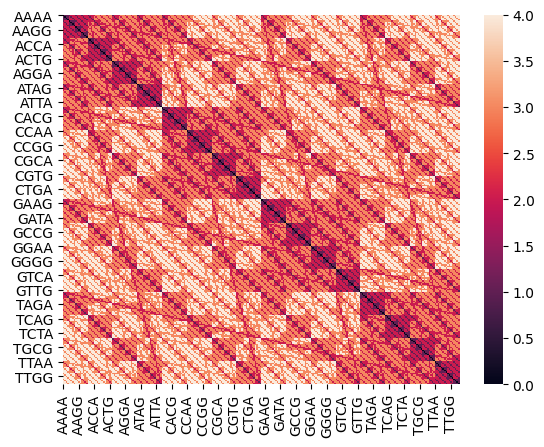

In [2]:
sns.heatmap(distance_matrix.astype(float))

In [3]:
bsdata = dict()
nonbsdata = dict()
for input_set in metadata.Set.unique():
    bsdata[input_set] = metadata[metadata.Set == input_set].BS_labcode.unique()
    nonbsdata[input_set] = metadata[metadata.Set == input_set].nonBS_labcode.unique()

In [4]:
#####-----------------------------------------------------------------#####
##### barycenter of each test set in BS and nonBS
#####-----------------------------------------------------------------#####

bs_barycenterdf = pd.DataFrame()
for run in tqdm(bsdata.keys()):
    available_samples = [item for item in bsdata[run] if item in bsdf.columns]
    print("Number of samples", len(available_samples))
    tmpdf = pd.DataFrame(data = calculate_barycenter(bsdf[available_samples].to_numpy(), show_plot = False, n = 256, M = M), columns = [run])
    bs_barycenterdf = pd.concat([bs_barycenterdf, tmpdf], axis = 1)
    
bs_barycenterdf["variance"] = bs_barycenterdf.var(axis = 1)

nonbs_barycenterdf = pd.DataFrame()
for run in tqdm(nonbsdata.keys()):
    available_samples = [item for item in nonbsdata[run] if item in nonbsdf.columns]
    print("Number of samples", len(available_samples))
    tmpdf = pd.DataFrame(data = calculate_barycenter(nonbsdf[available_samples].to_numpy(), show_plot = False, n = 256, M = M), columns = [run])
    nonbs_barycenterdf = pd.concat([nonbs_barycenterdf, tmpdf], axis = 1)
    
nonbs_barycenterdf["variance"] = nonbs_barycenterdf.var(axis = 1)



100%|██████████| 8/8 [00:00<00:00, 182.49it/s]


Number of samples 250
Number of samples 16
Number of samples 45
Number of samples 120
Number of samples 52
Number of samples 13
Number of samples 27
Number of samples 28


100%|██████████| 8/8 [00:00<00:00, 502.07it/s]

Number of samples 250
Number of samples 16
Number of samples 45
Number of samples 120
Number of samples 53
Number of samples 13
Number of samples 36
Number of samples 0


In [5]:
nonbs_dist = dict()
for input_test_set in [item for item in nonbsdata.keys() if "test" in item and item != "test6"]:
    nonbs_dist[input_test_set] = ot_distance(
        nonbs_barycenterdf[input_test_set].to_numpy(), 
        nonbs_barycenterdf["train"].to_numpy(), n = 256, M = M)
nonbs_dist = pd.DataFrame.from_dict(nonbs_dist, orient = "index", columns = ["nonBS_dist"])
bs_dist = dict()
for input_test_set in [item for item in bsdata.keys() if "test" in item and item != "test6"]:
    bs_dist[input_test_set] = ot_distance(
        bs_barycenterdf[input_test_set].to_numpy(), 
        bs_barycenterdf["train"].to_numpy(), n = 256, M = M)
bs_dist = pd.DataFrame.from_dict(bs_dist, orient = "index", columns = ["bs_dist"])

In [6]:
compare_dist = pd.concat([nonbs_dist, bs_dist], axis = 1)
compare_dist = pd.melt(compare_dist.reset_index(), id_vars=['index'], var_name='Variable', value_name='Value')

<Axes: xlabel='index', ylabel='Value'>

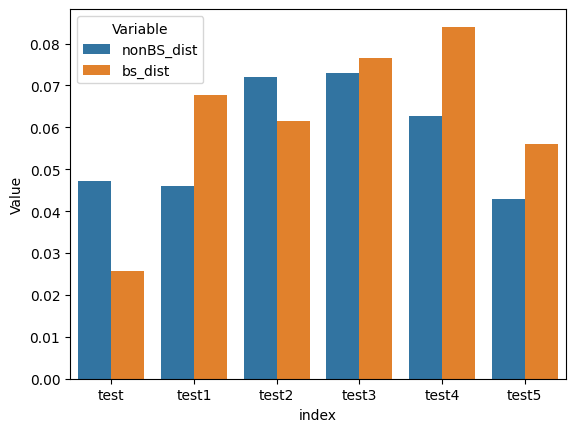

In [7]:
 sns.barplot(x='index', y='Value', data=compare_dist, hue = "Variable")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nonBS_dist v.s. bs_dist: t-test independent samples with Bonferroni correction, P_val=6.554e-01 stat=-4.599e-01


(<Axes: xlabel='Variable', ylabel='Value'>,
 [<statannot.StatResult.StatResult at 0x17ff36970>])

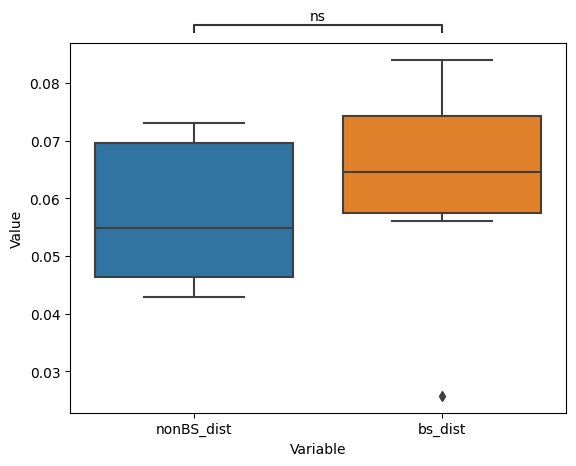

In [8]:
from statannot import add_stat_annotation
ax = sns.boxplot(x='Variable', y='Value', data=compare_dist)

# Add p-values
add_stat_annotation(ax, data=compare_dist, x='Variable', y='Value',
                    box_pairs=[('nonBS_dist', 'bs_dist')],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)


<Axes: >

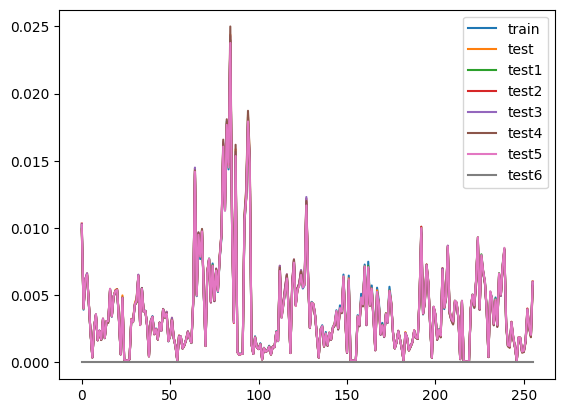

In [9]:
nonbs_barycenterdf.drop("variance", axis = 1).plot()

<Axes: >

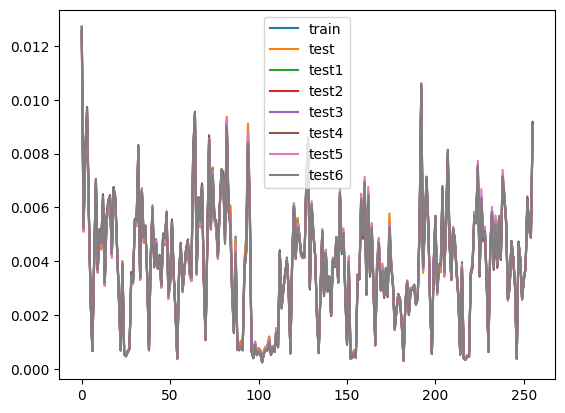

In [10]:
bs_barycenterdf.drop("variance", axis = 1).plot()